# Convolutions in action

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


Here we have 3 input features per pixel (the RGB channels) and an arbitrary number of channels in the output (16). We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we’ll get, even after training, will turn out to be useless.2 Let’s stick to a kernel size of 3 × 3. A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image.

In our case, both the kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particu- larly meaningful. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a Batches × Channels × Height × Width shaped tensor as input.

In [4]:
conv = nn.Conv2d(3, 16, kernel_size=3)
print('Shape of kernel weights and bias')
print(conv.weight.shape, conv.bias.shape)
print('')
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
print('Shape of input and output')
print(img.unsqueeze(0).shape, output.shape)

Shape of kernel weights and bias
torch.Size([16, 3, 3, 3]) torch.Size([16])

Shape of input and output
torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


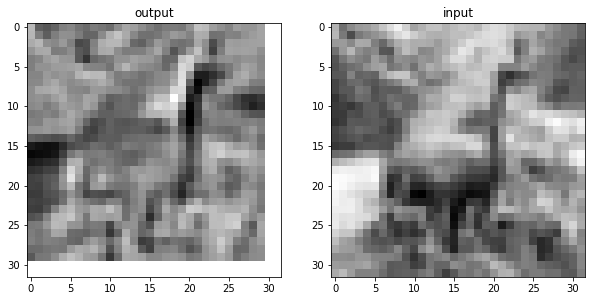

In [5]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

#### Kernel 1
Each pixel in the output gets the mean of its neighbor (3x3)

torch.Size([1, 3, 32, 32]) torch.Size([1, 1, 32, 32])
Output after appplying the Kernel that averages based on neighborhood pixels


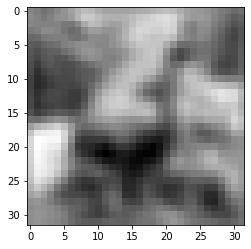

In [6]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape, output.shape)
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
    
print('Output after appplying the Kernel that averages based on neighborhood pixels')
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

#### Kernel 2
convolution kernel enhances the vertical edges. When an edge is "detected" that means that the output has a high magnitude.

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

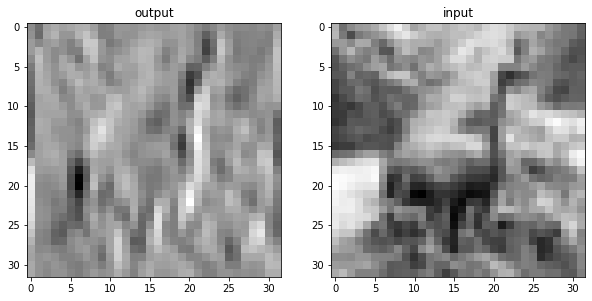

In [8]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [ ]:
ling operation

#### Downsampling technique example
Downsample our image by half by using the max pooling technique, we’ll want to use a size of 2.

In [10]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### NN structure
1. The 1st convolution takes us from 3 RGB channels to 16. These 16 independent features are being used to discriminate low-level features of birds and airplanes
2. The tanh activation function and yield a resulting 16-channel 32x32 image
3. Applying MaxPool2d(2) module shrinks the output to a 16-channel 16x16 image.
4. The image is convolved and yields an 8 channel 16 x 16 output which will consist of higher level features
5. The tanh activation function and yield a resulting 8-channel 16x16 image
6. Applying MaxPool2d(2) module shrinks the output to a 8-channel 8x8 image

In [12]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #1
            nn.Tanh(), #2
            nn.MaxPool2d(2), #3
            nn.Conv2d(16, 8, kernel_size=3, padding=1), #4
            nn.Tanh(), #5
            nn.MaxPool2d(2),#6
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [16]:
numel_list = [p.numel() for p in model.parameters()]
print('Total number of parameters:' + '\n' + str(sum(numel_list)))
print('Number of parameters per layer:' + '\n' + str(numel_list))

Total number of parameters:
18090
Number of parameters per layer:
[432, 16, 1152, 8, 16384, 32, 64, 2]
